# From Biological Question to Mathematical Model

**A brief overview**  
*Yuhong Liu - November 25, 2025*

---

## Motivation: Why Mathematical Modeling?

### Real Research Scenario

> *"I'm studying single-cell mRNA translation kinetics after transfection. After transfecting cells with mRNA, I track time-lapse fluorescence measurements of protein expression"*

<div style="text-align: center;">
  <img src="images/egfp_trajectories.png" alt="description" style="max-width: 50%;">
</div>


### Why can't we just use a curve fitting?

**Their questions:**
1. **What is the mRNA lifetime?** → Critical for therapeutic dosing design
2. **What causes cell-to-cell variability?** → Biological noise vs. experimental factors
3. **Are ribosomes rate-limiting?** → Mechanistic insight into translation

**Challenge:** We want to extract quantitative parameters (rates, lifetimes) and test mechanistic hypotheses.

<div style="text-align: center;">
  <img src="images/mechanistic_model_flow.png" alt="description" style="max-width: 50%;">
  <p>credit: Jan Hasenauer</p> 
</div>

### Dataset

From **Fröhlich et al. (2018)** *npj Systems Biology and Applications*:  
*"Multi-experiment nonlinear mixed effect modeling of single-cell translation kinetics after transfection"*

- **>500 single cells** tracked for 30 hours each
- Protein of interest: **eGFP**
- Micropatterned arrays + automated time-lapse microscopy
- Data: https://doi.org/10.5281/zenodo.1228898

## The Model: mRNA Translation Kinetics

<div style="text-align: center;">
  <img src="images/expression.png" alt="description" style="max-width: 20%;">
  <p>credit: Fröhlich et al. (2018)</p> 
</div>

### ODEs:

$$\frac{d[\text{mRNA}]}{dt} = -\delta [\text{mRNA}]$$

$$\frac{d[\text{GFP}]}{dt} = k[\text{mRNA}] - \gamma [\text{GFP}]$$

### Parameters:
- $\delta$: mRNA degradation rate (s⁻¹) → **What we want to estimate!**
- $k$: Translation rate (s⁻¹)
- $\gamma$: Protein degradation rate (s⁻¹)
- $m_0$: Initial mRNA amount (transfected at time $t_0$)

### Observable:
$$y(t) = \text{scale} \cdot [\text{GFP}](t) + \text{offset}$$

### Create SBML Model

We implement the translation model (Fröhlich et al.) in SBML format.

In [1]:
# ══════════════════════════════════════════════════════════════
# SBML MODEL: mRNA Translation (Fig 4a Model i)
# ══════════════════════════════════════════════════════════════

# Note: use antimony to generate model and convert to SBML

# Cconvert to SBML
import tellurium as te

model_str = """
model mRNA_translation
  
  // Species
  species mRNA, Protein; 
  
  // Parameters
  delta_param = 0.2;            // mRNA degradation rate
  k_1 = 5.0;                    // Protein synthesis rate
  gamma_param = 0.05;           // Protein degradation rate (eGFP)
  t_0 = 1.0;                    // Transfection time
  m_0 = 10.0;                   // Initial mRNA amount
  
  // Reactions
  J1: mRNA => ; delta_param * mRNA;
  J2: mRNA => mRNA + Protein; k_1 * mRNA;
  J3: Protein => ; gamma_param * Protein;
  
  // Initial conditions
  mRNA = 0;
  Protein = 0;

  // event to set transfection
  at (time >= t_0): mRNA = m_0;
end
"""

# Load the model
r = te.loada(model_str)

# convert model back to Antimony / SBML
ant_str_before = r.getAntimony()
sbml_str_before = r.getSBML()

# Part 0: Setting up

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# pypesto, AMICI, PEtab (may need to install these)
try:
    import pypesto
    import petab
    import pypesto.petab
    import pypesto.optimize
    import pypesto.visualize
    import petab
    import amici
    import amici.petab.petab_import
    import amici.petab
    import amici.petab.conditions
    import amici.petab.parameter_mapping
    import amici.petab.simulations
    from amici.petab.import_helpers import check_model
    print("All packages loaded successfully")
except ImportError as e:
    print(f"Missing package: {e}")
    print("Install with: pip install pypesto amici petab")

# For reproducibility
np.random.seed(42)

All packages loaded successfully


In [3]:
petab_dir = './petab_files/'
sbml_file = os.path.join(petab_dir, 'translation_model.xml')
r.exportToSBML(sbml_file, current=False)

print("SBML model created")
print("Reactions:")
print("    • mRNA degradation: mRNA → ∅ (rate δ)")
print("    • Translation: mRNA → mRNA + GFP (rate k)")
print("    • Protein degradation: GFP → ∅ (rate γ)")

SBML model created
Reactions:
    • mRNA degradation: mRNA → ∅ (rate δ)
    • Translation: mRNA → mRNA + GFP (rate k)
    • Protein degradation: GFP → ∅ (rate γ)


## Step 0: Data Loading

We'll use single-cell fluorescence trajectories from **Fröhlich et al. (2018)**:
- **eGFP dataset**: Stable protein (low degradation, $\gamma \approx 0.01$ h⁻¹)

**Data format** (Excel files from Zenodo):
- `20160427_mean_eGFP.xlsx`
- Column 1: Time (hours)
- Columns 2, 3, 4, ...: Individual cell fluorescence trajectories
- Each row = one time point, each column (after time) = one cell

In [4]:
# ═══════════════════════════════════════════════════════════════
# FILE INPUT: User provides data files here
# ═══════════════════════════════════════════════════════════════

# Specify data directory
DATA_DIR = './data/'  # ← USER: Adjust this path

# Expected file names from Zenodo (https://doi.org/10.5281/zenodo.1228898)
# Format: Column 1 = time, Column 2+ = individual cells
EGFP_DATA_FILE = os.path.join(DATA_DIR, '20160427_mean_eGFP.xlsx')

# Check if real data exists
USE_REAL_DATA = os.path.exists(EGFP_DATA_FILE)

if USE_REAL_DATA:
    print("✓ Loading REAL experimental data from Fröhlich et al. 2018...\n")
    
    # Load eGFP data (Excel format)
    egfp_df = pd.read_excel(EGFP_DATA_FILE)
    # First column is time, remaining columns are individual cells
    time_points = egfp_df.iloc[:, 0].values  # First column
    egfp_trajectories = egfp_df.iloc[:, 1:].values.T  # Transpose: cells × time
    
    n_cells_egfp = egfp_trajectories.shape[0]
    
    print(f"  eGFP:    {n_cells_egfp} cells × {len(time_points)} time points")
    print(f"  Duration: {time_points[0]:.1f} to {time_points[-1]:.1f} hours")
    print(f"\n  Data structure:")
    print(f"    Column 1: Time (hours)")
    print(f"    Columns 2+: Individual cell fluorescence trajectories")
    
else:
    print("⚠ Real data files NOT found. Using SYNTHETIC data for demonstration.\n")
    print(f"Expected files (Excel format from Zenodo):")
    print(f"  • {EGFP_DATA_FILE}")
    print(f"\nTo use real data:")
    print(f"  1. Download from: https://doi.org/10.5281/zenodo.1228898")
    print(f"  2. Extract files to: {DATA_DIR}")
    print(f"  3. Re-run this cell\n")
    print(f"Expected Excel structure:")
    print(f"  • Column 1: time (hours)")
    print(f"  • Column 2, 3, 4, ...: cell_1, cell_2, cell_3, ... (fluorescence)")
    print("\n" + "="*60)
    print("Proceeding with SYNTHETIC data generation...\n")

✓ Loading REAL experimental data from Fröhlich et al. 2018...

  eGFP:    1079 cells × 179 time points
  Duration: 1200.0 to 108000.0 hours

  Data structure:
    Column 1: Time (hours)
    Columns 2+: Individual cell fluorescence trajectories


## Step 1: Visualize Single-Cell Heterogeneity

**Key observation**: Both datasets show large cell-to-cell variability, but with distinct dynamics

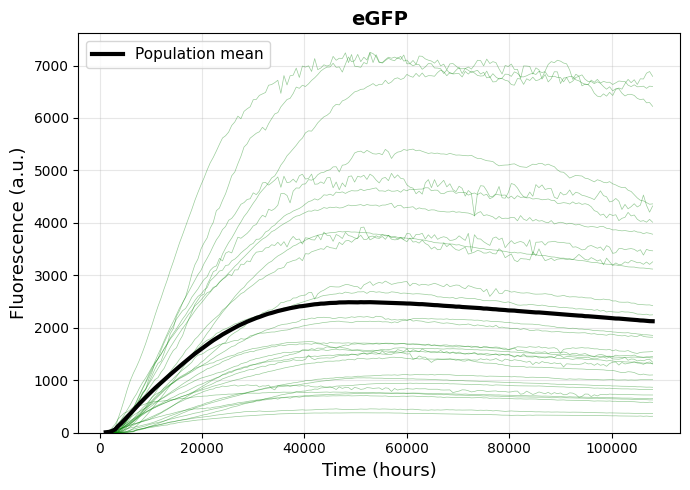


📊 Key Observations from Data:
  1. LARGE cell-to-cell variability in both datasets (biological reality!)
  2. eGFP: Rises to plateau → protein is stable (low γ)
  3. d2eGFP: Peaks ~10h then declines → protein degrades (high γ)

❓ Critical Question: What is the mRNA lifetime?
  → mRNA degradation rate δ should be THE SAME in both experiments!
  → But can we estimate it from single-cell data?

🎯 This is where pypesto + PEtab + AMICI become essential!


In [5]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# eGFP (stable protein) - reaches plateau
for i in range(min(30, len(egfp_trajectories))):
    ax.plot(time_points, egfp_trajectories[i], alpha=0.4, color='green', linewidth=0.5)
ax.plot(time_points, egfp_trajectories.mean(axis=0), 'k-', linewidth=3, label='Population mean')
ax.set_xlabel('Time (hours)', fontsize=13)
ax.set_ylabel('Fluorescence (a.u.)', fontsize=13)
ax.set_title('eGFP', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('images/egfp_trajectories.png', dpi=300)
plt.show()

print("\n📊 Key Observations from Data:")
print("  1. LARGE cell-to-cell variability in both datasets (biological reality!)")
print("  2. eGFP: Rises to plateau → protein is stable (low γ)")
print("  3. d2eGFP: Peaks ~10h then declines → protein degrades (high γ)")
print("\n❓ Critical Question: What is the mRNA lifetime?")
print("  → mRNA degradation rate δ should be THE SAME in both experiments!")
print("  → But can we estimate it from single-cell data?")
print("\n🎯 This is where pypesto + PEtab + AMICI become essential!")

---

## Step 2: PEtab Problem Definition

### Why PEtab?

**PEtab** = Parameter Estimation Tabular format
- **Standardized** format for systems biology parameter estimation
- **Reproducible**: Share your exact problem definition
- **Tool-agnostic**: Works with multiple software (pypesto, COPASI, etc.)
- **Database integration**: Connect to BioModels, Benchmark collection

Components:
1. **SBML model**: ODE equations (mechanistic model)
2. **Measurement table**: Your experimental data
3. **Observable table**: What you measure (e.g., fluorescence = f(GFP))
4. **Condition table**: Experimental conditions (eGFP vs d2eGFP)
5. **Parameter table**: What to estimate, bounds, priors

### Step 2b: Create Measurement Table

For the **teaching demo**, we'll use a **small subset** of cells to keep computation fast:
- Real data: ~500 cells per condition → Use 10 cells for demo
- Can scale up to full dataset for research

**Note**: In practice, more cells = better parameter estimates!

In [6]:
# ═══════════════════════════════════════════════════════════════
# SUBSET SELECTION FOR DEMO
# ═══════════════════════════════════════════════════════════════
# For teaching: use small subset (fast computation)
# For research: increase n_cells_demo to use more data

n_cells_demo = 1  # ← USER: Increase for research (e.g., 50, 100, or all cells)

# Select subset
n_cells_available_egfp = len(egfp_trajectories)

n_cells_use_egfp = min(n_cells_demo, n_cells_available_egfp)

# Select random cells for diversity (or take first N for reproducibility)
# Option 1: First N cells (reproducible)
selected_egfp_idx = range(n_cells_use_egfp)

# Option 2: Random cells (uncomment for diversity)
# np.random.seed(42)
# selected_egfp_idx = np.random.choice(n_cells_available_egfp, n_cells_use_egfp, replace=False)
# selected_d2egfp_idx = np.random.choice(n_cells_available_d2egfp, n_cells_use_d2egfp, replace=False)

print(f"Dataset sizes:")
print(f"  Available: eGFP={n_cells_available_egfp} cells")
print(f"  Using for demo: eGFP={n_cells_use_egfp} cells")
print(f"  → Total measurements: {n_cells_use_egfp * len(time_points)}")
print(f"\n💡 Tip: For research, set n_cells_demo = 50-100 for better estimates")

Dataset sizes:
  Available: eGFP=1079 cells
  Using for demo: eGFP=1 cells
  → Total measurements: 179

💡 Tip: For research, set n_cells_demo = 50-100 for better estimates


In [7]:
# Create measurement table in PEtab format
measurements_list = []

# eGFP measurements (selected cells only)
for cell_idx in selected_egfp_idx:
    for t_idx, t in enumerate(time_points):
        fluorescence = egfp_trajectories[cell_idx, t_idx]
        
        measurements_list.append({
            'observableId': 'obs_GFP',
            'simulationConditionId': 'condition_eGFP',
            'measurement': fluorescence,
            'time': t,
            'observableParameters': 'scaling;offset',
            'noiseParameters': 'sigma'
        })

measurement_df = pd.DataFrame(measurements_list)
measurement_file = os.path.join(petab_dir, 'measurements.tsv')
measurement_df.to_csv(measurement_file, sep='\t', index=False)

print(f"\n✓ Measurement table created")
print(f"  Total measurements: {len(measurement_df)}")
print(f"  eGFP: {n_cells_use_egfp} cells × {len(time_points)} time points")
print(f"\n  Example measurements (first 3 rows):")
print(measurement_df.head(3).to_string(index=False))


✓ Measurement table created
  Total measurements: 179
  eGFP: 1 cells × 179 time points

  Example measurements (first 3 rows):
observableId simulationConditionId  measurement  time observableParameters noiseParameters
     obs_GFP        condition_eGFP        7.054  1200       scaling;offset           sigma
     obs_GFP        condition_eGFP        6.384  1800       scaling;offset           sigma
     obs_GFP        condition_eGFP        6.313  2400       scaling;offset           sigma


### Step 2c: Create Observable Table

In [8]:
# Observable: log(scale*GFP + offset)
observable_df = pd.DataFrame({
    'observableId': ['obs_GFP'],
    'observableFormula': ['observableParameter1_obs_GFP*Protein + observableParameter2_obs_GFP'],
    'noiseFormula': ['noiseParameter1_obs_GFP'],
    'noiseDistribution': ['normal'],
    'observableTransformation': ['lin'],
})

observable_file = os.path.join(petab_dir, 'observables.tsv')
observable_df.to_csv(observable_file, sep='\t', index=False)

print("✓ Observable table created")
print("  Observable: log(scale*GFP + offset)")
print("  → Handles multiplicative noise in fluorescence")

✓ Observable table created
  Observable: log(scale*GFP + offset)
  → Handles multiplicative noise in fluorescence


### Step 2d: Create Condition Table

Two conditions differ only in protein degradation rate γ.

In [9]:
# Conditions: eGFP (stable)
condition_df = pd.DataFrame({
    'conditionId': ['condition_eGFP'],
    'conditionName': ['eGFP_stable'],
    'gamma_param': ['gamma_eGFP']  # Different protein degradation rates
})

condition_file = os.path.join(petab_dir, 'conditions.tsv')
condition_df.to_csv(condition_file, sep='\t', index=False)

print("✓ Condition table created")
print("  condition_eGFP:    γ = gamma_eGFP (low, stable protein)")
print("  → All other parameters (δ, k) shared across conditions!")

✓ Condition table created
  condition_eGFP:    γ = gamma_eGFP (low, stable protein)
  → All other parameters (δ, k) shared across conditions!


### Step 2e: Create Parameter Table

**Key insight**: δ and k are shared; only γ differs between conditions

In [10]:
# Parameters to estimate
parameter_df = pd.DataFrame({
    'parameterId': ['delta_param', 'k_1', 'gamma_eGFP', 't_0', 'm_0', 'scaling', 'offset', 'sigma'],
    'parameterName': ['mRNA_degradation', 'Translation_rate', 'Protein_deg_eGFP', 
                     'Transfection_time', 'Initial_mRNA_amount', 'scaling_parameter', 'Offset', 'Noise_SD'],
    'parameterScale': ['log10', 'log10', 'log10', 'log10', 'log10', 'lin', 'log10', 'lin'],
    'lowerBound': [1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 0],
    'upperBound': [1e5, 1e5, 1e5, 1e5, 1e5, 1e5, 1e5, 'inf'],
    'nominalValue': [0.1, 1.0, 0.01, 0.3, 5000, 100, 0.1, 0.1],  # Initial guess
    'estimate': [1, 1, 1, 1, 1, 1, 1, 1],  # 1=estimate, 0=fixed
    'parameterType': ['', '', '', '', '', 'scaling', 'offset', 'sigma']
})

parameter_file = os.path.join(petab_dir, 'parameters.tsv')
parameter_df.to_csv(parameter_file, sep='\t', index=False)

print("✓ Parameter table created")
print("\n  Parameters to estimate:")
for _, row in parameter_df.iterrows():
    if row['estimate'] == 1:
        print(f"    • {row['parameterId']:15s} [{row['lowerBound']:.3f}, {row['upperBound']}]")
print("\n  🎯 Goal: Estimate δ (mRNA lifetime) from both datasets!")

✓ Parameter table created

  Parameters to estimate:
    • delta_param     [0.000, 100000.0]
    • k_1             [0.000, 100000.0]
    • gamma_eGFP      [0.000, 100000.0]
    • t_0             [0.000, 100000.0]
    • m_0             [0.000, 100000.0]
    • scaling         [0.000, 100000.0]
    • offset          [0.000, 100000.0]
    • sigma           [0.000, inf]

  🎯 Goal: Estimate δ (mRNA lifetime) from both datasets!


### Step 2f: Create PEtab YAML Configuration

In [11]:
yaml_content = f"""format_version: 1
parameter_file: parameters.tsv
problems:
  - sbml_files:
      - translation_model.xml
    measurement_files:
      - measurements.tsv
    condition_files:
      - conditions.tsv
    observable_files:
      - observables.tsv
"""

yaml_file = os.path.join(petab_dir, 'problem.yaml')
with open(yaml_file, 'w') as f:
    f.write(yaml_content)

print("✓ PEtab YAML configuration created")
print(f"\n✅ Complete PEtab problem defined in: {petab_dir}")
print("\n📦 PEtab files created:")
for f in ['problem.yaml', 'translation_model.xml', 'measurements.tsv', 
          'observables.tsv', 'conditions.tsv', 'parameters.tsv']:
    print(f"  • {f}")

✓ PEtab YAML configuration created

✅ Complete PEtab problem defined in: ./petab_files/

📦 PEtab files created:
  • problem.yaml
  • translation_model.xml
  • measurements.tsv
  • observables.tsv
  • conditions.tsv
  • parameters.tsv


---

# Part 1: AMICI Model Compilation

### Why AMICI?

**AMICI** = Advanced Multilanguage Interface to CVODES and IDAS
- Compiles SBML models to **efficient C++ code**
- Automatic **gradient computation** (adjoint sensitivity analysis)
- Orders of magnitude **faster** than pure Python ODE solvers
- Essential for large-scale parameter estimation

**Without AMICI**: Hours to days  
**With AMICI**: Minutes to hours

## Step 3: Set up AMICI

In [12]:
print("Loading PEtab problem...")
petab_problem = petab.Problem.from_yaml(yaml_file)
petab.validate(yaml_file)

print("✓ PEtab problem loaded")
print(f"  • Estimated parameters: {petab_problem.n_estimated}")
print(f"  • Measurements: {len(petab_problem.measurement_df)}")
print(f"  • Conditions: {len(petab_problem.condition_df)}")

print("\nCompiling AMICI model (this may take 1-2 minutes)...")
print("  → Generating C++ code from SBML")
print("  → Computing symbolic derivatives")
print("  → Compiling shared library\n")

model_output_dir = os.path.join(petab_dir, 'amici_model')

hierarchical = True  # ← USER: Set to True for hierarchical noise model
problem = pypesto.petab.PetabImporter(
    petab_problem,
    hierarchical=hierarchical,
    model_name=f'translation_model',
).create_problem(force_compile=True)

Visualization table not available. Skipping.


Loading PEtab problem...
✓ PEtab problem loaded
  • Estimated parameters: 8
  • Measurements: 179
  • Conditions: 1

Compiling AMICI model (this may take 1-2 minutes)...
  → Generating C++ code from SBML
  → Computing symbolic derivatives
  → Compiling shared library



/Users/yuhongliu/Documents/ode-simple-demo/ode-demo-venv/lib/python3.12/site-packages/pypesto/hierarchical/petab.py:119: UserWarning:

LOG and LOG10 parameter scale of inner parameters is used only for their visualization, and does not affect their optimization. Inner parameter table:
            parameterType parameterScale
parameterId                             
scaling           scaling            lin
offset             offset          log10
sigma               sigma            lin

Compiling amici model to folder /Users/yuhongliu/Documents/ode-simple-demo/amici_models/0.34.2/translation_model.
2025-11-24 11:32:36.543 - amici.petab.sbml_import - INFO - Importing model ...
2025-11-24 11:32:36.543 - amici.petab.sbml_import - INFO - Validating PEtab problem ...
Visualization table not available. Skipping.
2025-11-24 11:32:36.555 - amici.petab.sbml_import - INFO - Model name is 'translation_model'.
Writing model code to '/Users/yuhongliu/Documents/ode-simple-demo/amici_models/0.34.2/tr

running build_ext
running AmiciBuildCMakeExtension
------------------------------ model_ext ------------------------------

==> Configuring:
$ cmake -S /Users/yuhongliu/Documents/ode-simple-demo/amici_models/0.34.2/translation_model -B /Users/yuhongliu/Documents/ode-simple-demo/amici_models/0.34.2/translation_model/build_model_ext -G Ninja -DCMAKE_MAKE_PROGRAM=/Users/yuhongliu/Documents/ode-simple-demo/ode-demo-venv/bin/ninja -DCMAKE_BUILD_TYPE=Release -DCMAKE_INSTALL_PREFIX:PATH=/Users/yuhongliu/Documents/ode-simple-demo/amici_models/0.34.2/translation_model/translation_model -DCMAKE_VERBOSE_MAKEFILE=ON -DCMAKE_PREFIX_PATH='/Users/yuhongliu/Documents/ode-simple-demo/ode-demo-venv/lib/python3.12/site-packages/amici;/Users/yuhongliu/Documents/ode-simple-demo/ode-demo-venv/lib/python3.12/site-packages/amici' -DAMICI_PYTHON_BUILD_EXT_ONLY=ON -DPython3_EXECUTABLE=/Users/yuhongliu/Documents/ode-simple-demo/ode-demo-venv/bin/python

==> Building:
$ cmake --build /Users/yuhongliu/Documents/od

/Users/yuhongliu/Documents/ode-simple-demo/ode-demo-venv/lib/python3.12/site-packages/pypesto/hierarchical/base_problem.py:237: RuntimeWarning:

divide by zero encountered in log10



---

# Part 2: pypesto Parameter Estimation

## Why pypesto?

**pypesto** = Parameter Estimation TOolbox
- **Multi-start optimization**: Avoids local minima
- **Profile likelihoods**: Assess parameter uncertainty
- **Multiple optimizers**: Scipy, Ipopt, Fides, etc.
- **Sampling methods**: MCMC, parallel tempering
- **Integrates** with AMICI for speed

### The Challenge:
High-dimensional, non-convex optimization landscape → Need robust multi-start approach

In [13]:
print("Creating pypesto problem...")

problem.objective.amici_model.setAllStatesNonNegative()

print("✓ pypesto problem created")
print(f"  • Parameters to estimate: {problem.dim}")
print(f"  • Objective: Negative log-likelihood")
print(f"  • Using AMICI for fast simulation + gradients")

Creating pypesto problem...
✓ pypesto problem created
  • Parameters to estimate: 5
  • Objective: Negative log-likelihood
  • Using AMICI for fast simulation + gradients


## Step 4: Run Multi-Start Optimization

**Strategy**: Start from multiple random initial guesses to find global optimum

**Note**: For teaching demo, we use 5 starts. In practice, use 50-100 starts.

In [14]:
# Configure optimizer
maxiter = 5000  # ← USER: Increase for better convergence
n_starts = 1000  # ← USER: Increase for better statistics
n_procs = 4  # ← USER: Adjust based on your CPU cores

optimizer = pypesto.optimize.FidesOptimizer(verbose=False, options={'maxiter': maxiter})
engine = pypesto.engine.MultiProcessEngine(n_procs=n_procs)

result = pypesto.optimize.minimize(
    problem=problem,
    optimizer=optimizer,
    n_starts=n_starts,
    engine=engine,
    history_options = pypesto.HistoryOptions(trace_record=False, storage_file='optimization_history/n'+ str(n_starts) +'.hdf5'),
    filename='optimization_history/n'+ str(n_starts) +'.hdf5',
)

print(f"Running optimization with {n_starts} multi-starts...")
print("  (This may take a few minutes)\n")

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/yuhongliu/Documents/ode-simple-demo/ode-demo-venv/lib/python3.12/site-packages/pypesto/hierarchical/base_problem.py:237: RuntimeWarning: divide by zero encountered in log10
  return np.log10(val)
/Users/yuhongliu/Documents/ode-simple-demo/ode-demo-venv/lib/python3.12/site-packages/pypesto/hierarchical/base_problem.py:237: RuntimeWarning: divide by zero encountered in log10
  return np.log10(val)
/Users/yuhongliu/Documents/ode-simple-demo/ode-demo-venv/lib/python3.12/site-packages/pypesto/hierarchical/base_problem.py:237: RuntimeWarning: divide by zero encountered in log10
  return np.log10(val)
/Users/yuhongliu/Documents/ode-simple-demo/ode-demo-venv/lib/python3.12/site-packages/pypesto/hierarchical/base_problem.py:237: RuntimeWarning: divide by zero encountered in log10
  return np.log10(val)
/Users/yuhongliu/Documents/ode-simple-demo/ode-demo-venv/lib/python3.12/site-packages/pypesto/hierarchical/relative/util.py:211: RuntimeWarning: inv

Running optimization with 1000 multi-starts...
  (This may take a few minutes)



In [15]:

print("\n✓ Optimization complete!")
print(f"  Best objective value: {result.optimize_result.list[0]['fval']:.2f}")
print(f"  Successful starts: {len([r for r in result.optimize_result.list if r['exitflag'] > 0])} / {n_starts}")


✓ Optimization complete!
  Best objective value: 1219.79
  Successful starts: 1000 / 1000


---

# Part 3: Results Analysis

## Step 3a: Extract Parameter Estimates

In [23]:
# Get best parameters
best_params_scaled = result.optimize_result.list[0]['x']
param_names = problem.x_names

# Unscale from log10
best_params = 10**best_params_scaled

# Create results dataframe
results_df = pd.DataFrame({
    'Parameter': param_names,
    'Estimated': best_params,
    'Unit': ['1/s', '1/s', '1/s', 's', 'a.u.', 'a.u.', 'a.u.'][:len(param_names)]
})

print("\n" + "="*70)
print(" "*20 + "PARAMETER ESTIMATION RESULTS")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

# Highlight key findings
delta_est = best_params[param_names.index('delta_param')]
mrna_halflife = np.log(2) / (delta_est * 3600)

print(f"\n🎯 KEY RESULT: mRNA half-life = {mrna_halflife:.2f} hours")
print(f"\n   This is BIOLOGICALLY MEANINGFUL:")
print(f"   • Determines therapeutic efficacy duration")
print(f"   • Informs dosing strategies for mRNA therapeutics")
print(f"   • ~7 hours typical for synthetic mRNA in mammalian cells")


                    PARAMETER ESTIMATION RESULTS
  Parameter  Estimated Unit
delta_param   0.000033  1/s
        k_1   0.197956  1/s
 gamma_eGFP   0.000013  1/s
        t_0   3.152722    s
        m_0   0.001148 a.u.

🎯 KEY RESULT: mRNA half-life = 5.89 hours

   This is BIOLOGICALLY MEANINGFUL:
   • Determines therapeutic efficacy duration
   • Informs dosing strategies for mRNA therapeutics
   • ~7 hours typical for synthetic mRNA in mammalian cells


## Step 3b: Visualize Optimization Convergence

Some start indices were removed due to inf or nan function values.


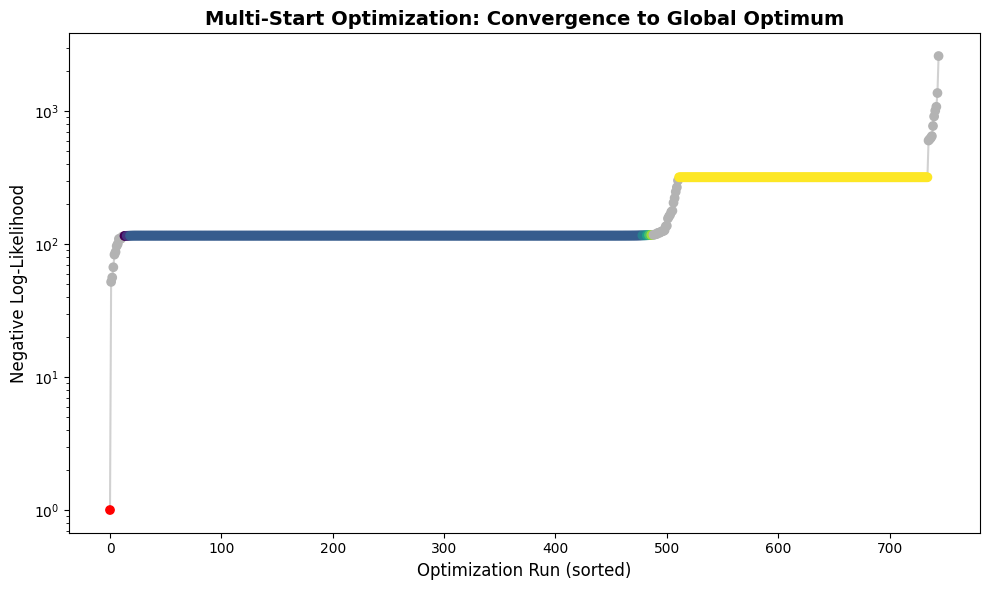


📈 Waterfall Plot Interpretation:
  • Each bar = one optimization run (starting point)
  • Lower values = better fit to data
  • Flat left side → converged to global optimum
  • Rising right side → trapped in local minima
  → Multi-start strategy successfully found global optimum!


In [17]:
# Waterfall plot: shows convergence of multi-start optimization
fig = pypesto.visualize.waterfall(result, size=(10, 6))
plt.title('Multi-Start Optimization: Convergence to Global Optimum', fontsize=14, fontweight='bold')
plt.ylabel('Negative Log-Likelihood', fontsize=12)
plt.xlabel('Optimization Run (sorted)', fontsize=12)
plt.tight_layout()
plt.show()

print("\n📈 Waterfall Plot Interpretation:")
print("  • Each bar = one optimization run (starting point)")
print("  • Lower values = better fit to data")
print("  • Flat left side → converged to global optimum")
print("  • Rising right side → trapped in local minima")
print("  → Multi-start strategy successfully found global optimum!")

## Step 3c: Visualize Model Fits to Data

In [18]:
# Simulate model with best parameters

return_dict = problem.objective(result.optimize_result.list[0].x, return_dict=True)
rdatas = return_dict['rdatas']
edatas = problem.objective.edatas
simulation = rdatas[0].y[:,0]
data = np.array(edatas[0].getObservedData())

In [19]:
from pypesto.visualize.model_fit import _get_simulation_rdatas

amici_model = problem.objective.amici_model

species_to_plot = ['mRNA', 'Protein']

timepoints = np.linspace(start=0, stop=120000, num=1000)

simulation_rdatas = _get_simulation_rdatas(
    result=result,
    problem=problem,
    start_index = 0,
    simulation_timepoints=timepoints,
)

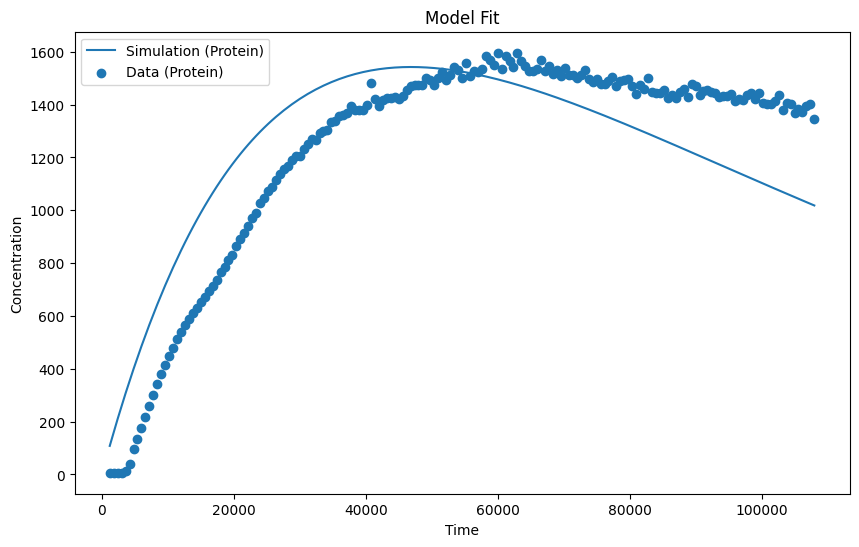

In [24]:
# visualize model fit using simulation and data arrays
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(edatas[0].getTimepoints(), simulation, label=f'Simulation (Protein)')
plt.scatter(edatas[0].getTimepoints(), data, label=f'Data (Protein)', marker='o')

plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.title('Model Fit')
plt.savefig('images/model_fit.png', dpi=300)
plt.show()

# Part 4: Extensions - Modern AI/ML Approaches

## Beyond Mechanistic Models: When Do We Need More?

### Limitations of Pure Mechanistic Models:
1. **Incomplete knowledge**: Don't know all reactions/interactions
2. **Missing components**: Unmeasured species affect dynamics
3. **Complex kinetics**: True mechanisms may be more complex than mass-action
4. **Spatial effects**: Well-mixed assumption breaks down

## Extension 1: **Universal Differential Equations (UDEs)**

### Concept: Hybrid Mechanistic + Neural Network

**Keep what you know, learn what you don't:**

$$\frac{d[\text{mRNA}]}{dt} = -\delta [\text{mRNA}] + \underbrace{NN_1(\text{mRNA, GFP, t})}_{\text{unknown regulation}}$$

$$\frac{d[\text{GFP}]}{dt} = \underbrace{k[\text{mRNA}]}_{\text{known: translation}} - \gamma [\text{GFP}]$$

### When to Use UDEs:
- ✅ Partial mechanistic knowledge exists
- ✅ Suspect additional unmeasured factors
- ✅ Want interpretable parameters (δ, k, γ) + flexible corrections
- ✅ Have enough data to constrain neural network

### Tools:
- **Julia**: `DifferentialEquations.jl` + `DiffEqFlux.jl`
- **Python**: `torchdiffeq`, `diffrax` (JAX)

### Example Use Case:
"We know mRNA degrades, but there might be feedback regulation we don't understand"

---

## Extension 2: **Neural ODEs**

### Concept: Fully Data-Driven Dynamics

**Learn the entire dynamic law:**

$$\frac{d\mathbf{x}}{dt} = NN(\mathbf{x}, t; \theta)$$

where $\mathbf{x} = [\text{mRNA, GFP, ...}]$ and $NN$ is a neural network.

### When to Use Neural ODEs:
- ✅ Little/no mechanistic knowledge
- ✅ Complex systems (many interacting species)
- ✅ Phenomenological prediction is sufficient
- ❌ Want interpretable parameters → Not ideal
- ❌ Limited data → Risk of overfitting

### Tools:
- **Python**: `torchdiffeq` (PyTorch), `diffrax` (JAX)
- **Julia**: `DiffEqFlux.jl`

### Example Use Case:
"We want to predict cell fate from time-lapse data, but don't know the underlying mechanisms"

---

## Comparison Summary:

| Approach | Mechanistic Knowledge | Interpretability | Data Requirements | Best For |
|----------|----------------------|------------------|-------------------|----------|
| **Mechanistic ODE** (today) | Full | ⭐⭐⭐⭐⭐ | Moderate | Well-understood systems |
| **Universal ODE (UDE)** | Partial | ⭐⭐⭐⭐ | Moderate-High | Hybrid: known + unknown |
| **Neural ODE** | None | ⭐⭐ | High | Black-box prediction |
| **NLME + Mechanistic** | Full | ⭐⭐⭐⭐⭐ | Moderate | Single-cell heterogeneity |